# 地层分类1dcnnLstmBiLSTM



In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D,BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
#设置中文显示
mpl.rcParams['font.sans-serif'] = ['SimHei']   #显示中文
mpl.rcParams['axes.unicode_minus']=False       #显示负号

In [3]:
def feature_normalize(dataset):
    mu = np.mean(dataset, axis=0)  # axis = 0:压缩行，对各列求均值，返回 1* n 矩阵
    sigma = np.std(dataset, axis=0)  # axis = 0:计算每一列的标准差
    return (dataset - mu) / sigma


# 显示 confusion matrix
def show_confusion_matrix(validations, predictions):
    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


# 打印传入的原始数据  显示的行数由preview_rows确定
def show_basic_dataframe_info(dataframe,
                              preview_rows=20):
    """
    This function shows basic information for the given dataframe
    Args:
        dataframe: A Pandas DataFrame expected to contain data
        preview_rows: An integer value of how many rows to preview
    Returns:
        Nothing
    """

    # Shape and how many rows and columns
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))
    print("Number of rows in the dataframe: %i\n" % (dataframe.shape[0]))
    print("First 20 rows of the dataframe:\n")
    # Show first 20 rows
    print(dataframe.head(preview_rows))
    print("\nDescription of dataframe:\n")
    # Describe dataset like mean, min, max, etc.
    # print(dataframe.describe())


# 转化为浮点数
def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan


'''
# Not used right now
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma
'''


# 图表显示
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(True)  # 设置x轴坐标轴不可见
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])  # 限制显示的范围
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


# 图表显示
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,  # 将一个figure分成3个子图，分别显示
                                        figsize=(15, 10),
                                        sharex=True)
    plot_axis(ax0, data['timestamp'], data['co-fli'], 'CO-Filtering')  # 自定义函数
    plot_axis(ax1, data['timestamp'], data['smog-fli'], 'Smog-Filtering')
    plot_axis(ax2, data['timestamp'], data['t-fli'], 'Temperature-Filtering')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()
    # subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    # 其中left、bottom、right、top围成的区域就是子图的区域。wspace、hspace分别表示子图之间左右、上下的间距。


# 接收read_data()处理好的txt文件里面的数据，转化为（reshape）cnn能够识别的数据帧
def create_segments_and_labels(df, time_steps, step, label_name, features):
    """
    This function receives a dataframe and returns the reshaped segments
    of x,y,z acceleration as well as the corresponding labels
    Args:
        df: Dataframe in the expected format
        time_steps: Integer value of the length of a segment that is created
    Returns:
        reshaped_segments
        labels:
    """

    # 传入传感器的个数
    N_FEATURES = len(features)
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        segment = []
        for feature in features:
            segment.append(df[feature].values[i:i + time_steps])
        # 寻找出现最多的标签
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append(segment)
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels
"""
history plot
"""
def plot_his(history):
  # summarize history for accuracy and loss
  # 训练集数据相关参数显示
  plt.figure(figsize=(6, 4))

  # plt.plot(history.history['acc'], "g--", label="Accuracy of training data")         # 版本不同传入不同的参数
  # plt.plot(history.history['val_acc'], "g", label="Accuracy of validation data")
  plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
  plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")

  plt.plot(history.history['loss'], "r--", label="Loss of training data")
  plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
  plt.title('Model Accuracy and Loss')
  plt.ylabel('Accuracy and Loss')
  plt.xlabel('Training Epoch')
  plt.ylim(0)
  plt.legend()
  plt.show()

def value_model_agnist_test(df_test, model_m):
  print("\n--- Check against test data ---\n")

  # Normalize features for training data set
  # 神经网络已经训练好，接下来是拿测试集进行测试。
  # 测试集的数据处理，类似训练集

  for f in features:
      df_test = df_test.round({f: 3})
      df_test[f] = feature_normalize(df[f])

  x_test, y_test = create_segments_and_labels(df_test,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              'Formation',
                                              features)

  # Set input_shape / reshape for Keras
  # x_test = x_test.reshape(x_test.shape[0], input_shape)

  x_test = x_test.astype("float32")
  y_test = y_test.astype("float32")

  y_test = np_utils.to_categorical(y_test, num_classes)

  # 调用评估函数测试测试集数据的准确度
  score = model_m.evaluate(x_test, y_test, verbose=1)

  # 测试集的参数（accuracy，loss）的显示
  print("\nAccuracy on test data: %0.2f" % score[1])
  print("\nLoss on test data: %0.2f" % score[0])

  # %%

  print("\n--- Confusion matrix for test data ---\n")

  y_pred_test = model_m.predict(x_test)
  # Take the class with the highest probability from the test predictions
  max_y_pred_test = np.argmax(y_pred_test, axis=1)
  max_y_test = np.argmax(y_test, axis=1)
  # 训练集的confusion matrix的显示
  show_confusion_matrix(max_y_test, max_y_pred_test)

  # %%

  print("\n--- Classification report for test data ---\n")

  print(classification_report(max_y_test, max_y_pred_test))

In [4]:
# 所有参数

# The number of steps within one time segment
# one time segment的长度,  宽度为特征个数
TIME_PERIODS = 160
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
# time segment 每次移动的步长 如过这个值和 TIME_PERIODS 相等，则两个 segment 之间没有重叠
STEP_DISTANCE = 1 

# 网络中 dropout 层的参数  0.5 表示有一半连接 随机置为 0
drop_pecent = 0.5
# 特征选择 GR_med_num 表示 滤波为 num 的 GR 中值滤波曲线
features = ['Depth', 'GR', 'AC', 'SP', 'INPEFA', 'GR_MED_3', 'GR_MED_5', 'GR_MED_7', 'GR_MED_9', 'GR_MED_11',
            'GR_MED_13', 'GR_MED_15', 'GR_MED_17', 'GR_MED_19', ]

keras version  2.8.0

--- Load, inspect and transform data ---

Number of columns in the dataframe: 16
Number of rows in the dataframe: 92284

First 20 rows of the dataframe:

    Depth   GR  INPEFA  AC   SP  Well Name  Formation  GR_MED_3  GR_MED_5  \
0    -0.1  0.0    -0.4 0.0 -0.5          0          0       0.0       0.0   
1    -0.1  0.1    -0.3 0.0 -0.5          0          0       0.1       0.1   
2    -0.1  0.2    -0.4 0.0 -0.5          0          0       0.2       0.2   
3    -0.1  0.4    -0.7 0.0 -0.6          0          0       0.4       0.3   
4    -0.1  0.4    -0.6 0.0 -0.6          0          0       0.4       0.3   
5    -0.1  0.3    -0.5 0.0 -0.6          0          0       0.3       0.3   
6    -0.1  0.2    -0.6 0.0 -0.6          0          0       0.2       0.2   
7    -0.1  0.1    -0.5 0.0 -0.7          0          0       0.1       0.1   
8    -0.1  0.1    -0.5 0.0 -0.7          0          0       0.1       0.1   
9    -0.1  0.0    -0.3 0.0 -0.6          0          0 

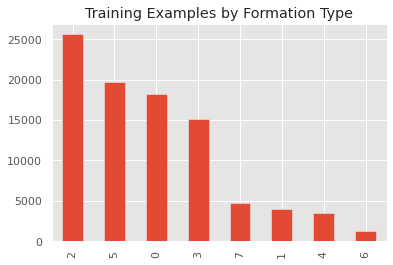

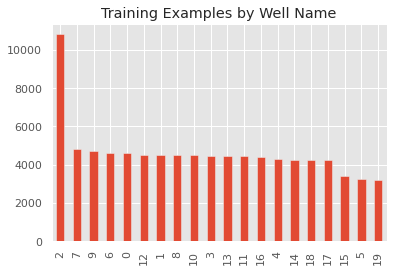


--- Reshape the data into segments ---



In [12]:
# ------- THE PROGRAM TO LOAD DATA AND TRAIN THE MODEL -------

# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set()  # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)

# 整个数据所有的数据标签
LABELS = ['龙潭组',
      '茅三段',
      '茅二段',
      '茅一段',
      '栖二段',
      '栖一段',
      '梁山组',
      '石炭系',
      ]

print("\n--- Load, inspect and transform data ---\n")

# Load data set containing all the data from csv
# 读取原始数据
df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/地层划分与对比/data/scalaredFetures_med9.csv')


# Describe the data
# 图表显示
# 原始数据 图表/数值 显示开关 dis_switch

dis_switch = True

if dis_switch:
    show_basic_dataframe_info(df, 20)

    # 柱状图显示

    df['Formation'].value_counts().plot(kind='bar',
                                        title='Training Examples by Formation Type')

    plt.show()

    df['Well Name'].value_counts().plot(kind='bar',
                                        title='Training Examples by Well Name')
    plt.show()

# Differentiate between test set and training set
# 用井号区分训练集和测试集 共 0 - 19口井
df_test = df[df['Well Name'] == 0]
df_train = df[df['Well Name'] > 0]
# Define column name of the label vector
LABEL = "FormationEncoded"
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# 标准化标签，将标签值统一转换成range(标签值个数-1)范围内
# Add a new column to the existing DataFrame with the encoded values
# 将数据中的字符标签转化为数字标签
df[LABEL] = le.fit_transform(df["Formation"].values.ravel())

print("\n--- Reshape the data into segments ---\n")


for f in features:
    df_train = df_train.round({f : 3})  # 保留3位小数点
# df_train = df_train.round({'Depth':3,'GR': 3, 'INPEFA': 3, 'AC': 3, 'SP': 3})  # 保留3位小数点

# Reshape the training data into segments
# so that they can be processed by the network
# x_train的数据为80×4的二维矩阵，y_train的数据为x_train数据对应的标签
x_train, y_train = create_segments_and_labels(df_train,
                        TIME_PERIODS,
                        STEP_DISTANCE,
                        "Formation",
                        features)

In [13]:
print("\n--- Reshape data to be accepted by Keras ---\n")

print('x_train shape origin: ', x_train.shape)

print(x_train.shape[0], 'training samples')

# Inspect y dataq
print('y_train shape: ', y_train.shape)
# Displays (20869,)

# Set input & output dimensions
# num_time_periods:TIME_PERIODS x_train的行数  num_sensors:传感器个数 x_train列数
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
# 打印数据中所有的标签
print(list(le.classes_))
# Set input_shape / reshape for Keras
# Remark: acceleration data is concatenated in one array in order to feed
# it properly into coreml later, the preferred matrix of shape [40,3]
# cannot be read in with the current version of coreml (see also reshape
# layer as the first layer in the keras model)
# keras不支持多维矩阵的输入，所以要将80×3的二维矩阵转化为长度为240的一维矩阵
input_shape = (num_time_periods * num_sensors)  # 80×3
print("input_shape:", input_shape)
x_train = x_train.reshape(x_train.shape[0], input_shape)

print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)

# Convert type for Keras otherwise Keras cannot process the data
# 转化为keras能够识别的float32类型
x_train = x_train.astype("float32")
y_train = y_train.astype("float32")


--- Reshape data to be accepted by Keras ---

x_train shape origin:  (87519, 160, 14)
87519 training samples
y_train shape:  (87519,)
[0, 1, 2, 3, 4, 5, 6, 7]
input_shape: 2240
x_train shape: (87519, 2240)
input_shape: 2240


In [7]:
# One-hot encoding：待定概念
# One-hot encoding of y_train labels (only execute once!只需执行一次)
# 待定，可能是x_train转换完成之后，y_train也要完成相应的转换
y_train = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train.shape)

New y_train shape:  (87519, 8)


In [ ]:
print("\n--- Create ResNet network model ---\n")

n_feature_maps = 64

input_layer = keras.layers.Input((160, 14))
Reshape_layer = keras.layers.Reshape((160, 14), input_shape = (160*14,))(input_layer)

# BLOCK 1

conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
conv_x = keras.layers.BatchNormalization()(conv_x)
conv_x = keras.layers.Activation('relu')(conv_x)

conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
conv_y = keras.layers.BatchNormalization()(conv_y)
conv_y = keras.layers.Activation('relu')(conv_y)

conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
conv_z = keras.layers.BatchNormalization()(conv_z)

# expand channels for the sum
shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

output_block_1 = keras.layers.add([shortcut_y, conv_z])
output_block_1 = keras.layers.Activation('relu')(output_block_1)

# BLOCK 2

conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
conv_x = keras.layers.BatchNormalization()(conv_x)
conv_x = keras.layers.Activation('relu')(conv_x)

conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
conv_y = keras.layers.BatchNormalization()(conv_y)
conv_y = keras.layers.Activation('relu')(conv_y)

conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
conv_z = keras.layers.BatchNormalization()(conv_z)

# expand channels for the sum
shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

output_block_2 = keras.layers.add([shortcut_y, conv_z])
output_block_2 = keras.layers.Activation('relu')(output_block_2)

# BLOCK 3

conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
conv_x = keras.layers.BatchNormalization()(conv_x)
conv_x = keras.layers.Activation('relu')(conv_x)

conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
conv_y = keras.layers.BatchNormalization()(conv_y)
conv_y = keras.layers.Activation('relu')(conv_y)

conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
conv_z = keras.layers.BatchNormalization()(conv_z)

# no need to expand channels because they are equal
shortcut_y = keras.layers.BatchNormalization()(output_block_2)

output_block_3 = keras.layers.add([shortcut_y, conv_z])
output_block_3 = keras.layers.Activation('relu')(output_block_3)

# FINAL

gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)

output_layer = keras.layers.Dense(8, activation='softmax')(gap_layer)

model = keras.models.Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)

print(model.summary())

In [ ]:
print("\n--- Fit the ResNet model ---\n")


callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='h5/best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
]

model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
# 每个batch的大小，也就是说每一个batch里面有400个传感器检测数据
BATCH_SIZE = 1024
# 训练次数,全部数据经过神经网络的遍数
EPOCHS = 100
# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
# model_m.fit():调用该函数，神经网络开始训练，前面只是将所有参数都设置好。

history = model.fit(x_train,
            y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            callbacks=callbacks_list,
            validation_split=0.4,# 在训练集的数据中将数据以8：2的比例分开（2/10=0.2），8的进行训练（train），2的进行核对（validation ）
            verbose=1)

In [ ]:
print("\n--- Learning curve of ResNet model training ---\n")
plot_his(history)
value_model_agnist_test(df_test, model)

In [ ]:
print("\n--- Create FCN network model ---\n")

model = keras.Sequential(
    [
        layers.Reshape((160, 14), input_shape=(160 * 14,)),

        layers.Conv1D(filters=128, kernel_size=8, padding='same'),
        layers.BatchNormalization(),
        layers.Activation(activation='relu'),

        layers.Conv1D(filters=256, kernel_size=5, padding='same'),
        layers.BatchNormalization(),
        layers.Activation(activation='relu'),
     
        layers.Conv1D(filters=512, kernel_size=3, padding='same'),
        layers.BatchNormalization(),
        layers.Activation(activation='relu'),

        layers.Conv1D(filters=128, kernel_size=3, padding='same'),
        layers.BatchNormalization(),
        layers.Activation(activation='relu'),

        layers.GlobalAveragePooling1D(),

        layers.Dense(8, activation='softmax')
    ]
)

print(model.summary())


In [ ]:
print("\n--- Fit the FCN model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
# 存放神经网络训练模型的文件（即后缀名为.h5的文件，放在该目录下的h5文件夹），
# 生成好的模型其他文件可以直接调用，而不用再次进行用神经网络进行训练
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='h5/best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)
]

model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
# 每个batch的大小，也就是说每一个batch里面有400个传感器检测数据
BATCH_SIZE = 1024
# 训练次数,全部数据经过神经网络的遍数
EPOCHS = 100
# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
# model_m.fit():调用该函数，神经网络开始训练，前面只是将所有参数都设置好。
history = model.fit(x_train,
            y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            callbacks=callbacks_list,
            validation_split=0.4,# 在训练集的数据中将数据以8：2的比例分开（2/10=0.2），8的进行训练（train），2的进行核对（validation ）
            verbose=1)

In [ ]:
print("\n--- Learning curve of 1DCNN model training ---\n")
plot_his(history)

In [14]:
print("\n--- Create 1D CNN network model ---\n")

# 1D CNN neural network
# 运用Keras一维卷积实现
model_m = Sequential()
# 输入数据（待定）
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
# 第一次卷积层 输入矩阵大小：80×3 输出矩阵大小：71×100
# kernel/patch size:10 filter size:100
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(BatchNormalization())
# 第二次卷积层  输入矩阵大小：71×100 输出矩阵大小：62×100
# kernel/patch size:10 filter size:100
model_m.add(Conv1D(100, 10, activation='relu'))
model_m.add(BatchNormalization())
# 最大值池化层 输入矩阵大小：62×100 stride size（步长）：3
# 输出矩阵：20×100
model_m.add(MaxPooling1D(3))
# 第三次卷积 输入矩阵大小：20×160 输出11×160
# kernel/patch size:10 filter size:160 
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(BatchNormalization())
# 第四次卷积 输入矩阵大小：11×160 输出2×160
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(BatchNormalization())
# 平均值池化层  输出1×160
model_m.add(GlobalAveragePooling1D())
# Dropout层
# 为减少过度拟合，部分数据被随机置0,在这里设置的为0.5（50%的数据被随机置0）
# model_m.add(Dropout(0.3))
# fully connected layer
# 使用softmax的激励函数
# 输入1×160 输出1×6
model_m.add(Dense(num_classes, activation='softmax'))

print(model_m.summary())
# Display:
# Accuracy on training data
# Accuracy on test data


--- Create 1D CNN network model ---

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 160, 14)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 151, 100)          14100     
                                                                 
 batch_normalization_4 (Batc  (None, 151, 100)         400       
 hNormalization)                                                 
                                                                 
 conv1d_5 (Conv1D)           (None, 142, 100)          100100    
                                                                 
 batch_normalization_5 (Batc  (None, 142, 100)         400       
 hNormalization)                                                 
                                                                 
 max_pooling1d_1

In [15]:
print("\n--- Fit the 1DCNN model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
# 存放神经网络训练模型的文件（即后缀名为.h5的文件，放在该目录下的h5文件夹），
# 生成好的模型其他文件可以直接调用，而不用再次进行用神经网络进行训练
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='h5/best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
# 每个batch的大小，也就是说每一个batch里面有400个传感器检测数据
BATCH_SIZE = 1024
# 训练次数,全部数据经过神经网络的遍数
EPOCHS = 100
# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
# model_m.fit():调用该函数，神经网络开始训练，前面只是将所有参数都设置好。
history = model_m.fit(x_train,
            y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            callbacks=callbacks_list,
            validation_split=0.4,# 在训练集的数据中将数据以8：2的比例分开（2/10=0.2），8的进行训练（train），2的进行核对（validation ）
            verbose=1)


--- Fit the 1DCNN model ---

Epoch 1/100


ValueError: ignored

In [ ]:
# %%

print("\n--- Learning curve of 1DCNN model training ---\n")
plot_his(history)


In [ ]:
print("\n--- Create LSTM network model ---\n")
from tensorflow import keras
from keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential

# parameters for LSTM
nb_lstm_outputs = 30  # 输出神经元个数
nb_time_steps = TIME_PERIODS  # 时间序列的长度
nb_input_vectors = len(features)  #

# define LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(128,input_shape=(nb_time_steps,14),return_sequences=True))  #返回所有节点的输出
model_lstm.add(LSTM(64,return_sequences=True))
model_lstm.add(LSTM(32,return_sequences=True))
model_lstm.add(LSTM(16,return_sequences=False))
model_lstm.add(Dropout(drop_pecent))
model_lstm.add(Dense(8,activation='softmax'))

# compile:loss, optimizer, metrics
model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model_lstm.summary()

In [ ]:
print("\n--- Fit the LSTM model ---\n")
x_train = x_train.reshape(-1, TIME_PERIODS, len(features))
EPOCH = 100
BATCH_SIZE = 128
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
]
history = model_lstm.fit(
    x_train,
    y_train,
    epochs=EPOCH,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_split=0.2,
    callbacks = callbacks_list
)

In [ ]:
print("\n--- Learning curve of lstm model training ---\n")

plot_his(history)

In [ ]:
print("\n--- Create BiLSTM network model ---\n")

# define BiLSTM
model_bilstm = Sequential()
lstm=LSTM(64,input_shape=(TIME_PERIODS,len(features)),return_sequences=False)  #返回最后一个节点的输出
model_bilstm.add(Bidirectional(lstm))
model_bilstm.add(Dense(num_classes, activation = 'softmax'))

# compile:loss, optimizer, metrics
model_bilstm.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
print("\n--- Fit the BiLSTM model ---\n")
x_train = x_train.reshape(-1, TIME_PERIODS, len(features))
EPOCH = 100
BATCH_SIZE = 128
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
]
history = model_bilstm.fit(
    x_train,
    y_train,
    epochs=EPOCH,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_split=0.2,
    callbacks = callbacks_list
)

In [ ]:
model_bilstm.summary()

In [ ]:
print("\n--- Learning curve of BiLSTM model training ---\n")

plot_his(history)

In [ ]:
# %%

print("\n--- Check against test data ---\n")

# Normalize features for training data set
# 神经网络已经训练好，接下来是拿测试集进行测试。
# 测试集的数据处理，类似训练集

for f in features:
  df_test = df_test.round({f : 3})

# df_test = df_test.round({'GR': 3, 'INPEFA': 3, 'AC': 3, 'SP': 3})

x_test, y_test = create_segments_and_labels(df_test,
                      TIME_PERIODS,
                      STEP_DISTANCE,
                      "Formation",
                      features)

# Set input_shape / reshape for Keras
x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype("float32")
y_test = y_test.astype("float32")

y_test = np_utils.to_categorical(y_test, num_classes)

# 调用评估函数测试测试集数据的准确度
score = model.evaluate(x_test, y_test, verbose=1)

# 测试集的参数（accuracy，loss）的显示
print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

In [ ]:

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)
# 训练集的confusion matrix的显示
show_confusion_matrix(max_y_test, max_y_pred_test)

In [ ]:
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))